### Logistic Regression
first using it on PCA projected data, then on non-projected (but standardized) data, then finally on just the 'normal' data

**PCA projected data (+ standardized)**
- I used some pretty basic hyperparams for this one, no regularization as well. 
- Not surprisingly I got an accuracy score of around *23%* for a logistic regression trained on this data. The reason it's not surprising is because there were no clear separations of the classes when the first 2 principal components were plotted against each other (as seen right above). It would be interesting to try and tune this model to see it's highest potential.
- The confusion matrix provides a lot of interesting information on the predictions of the model. 
    - the model made *0* predictions for class 2 (bird) and had the most correct predictions for class 8 (ship).
    - it's intriguing b/c in the test target distribution, class 2 is seen the most.  
    - classes 1, 2, and 3 were the least predicted classes

**Standardized data**
- something I forgot to think about was the time it took for each epoch. the PCA data only had 3 features (3 components) this data has 3072. Each epoch was much longer relative to PCA projected data
- model did marginally better than previous, with a test accuracy of *35.77%*. I believe the model also might have overfitted a bit since the train accuracy was much better at *56.12%*. I'd have to take a look at the coefficients and see whether L1, L2, or elasticnet regularization would be best.


**Unprocessed data**
- Model converged a lot quicker than the standardized data
- The model also did better than the others with a test accuracy of *38.30%*, but overfitting training data seemed to still be the case since the train accuracy was *49.97%*
- The confusion matrix for this model looked the best as the main diagonal had more values than the other confusion matrices. 


Overall, a logistic regression is not a particularly good choice of model for this kind of data (images). I think tuning and perhaps specialized preprocessing could get you a bit more accuracy points, but relative to a CNN, it probably won't be worth the effort. Maybe another day I'll try to tune, regularize, do some interesting data processing, feature selection, and/or feature extraction to squeeze out a better score. Until then I'm moving on to other models. Also in the end, even though all these models were untuned, the one that was trained on unprocessed data did the best while balancing overfitting. 

In [1]:
import pandas
import seaborn as sns
from sklearn.datasets import fetch_openml
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

In [2]:
X, y = fetch_openml('CIFAR_10_small', as_frame=True, return_X_y=True, parser='auto')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=27)

# create dict of output to class names according to openml metadata
classes = { 0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [3]:
# standardize and apply pca
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)    # 'fit' a standardization for the train data so no test mean and std leaks to model
X_test_std = scaler.transform(X_test)

pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_std)   # decompose principal components from training data
X_test_pca = pca.transform(X_test_std)   

In [4]:
# training on PCA projected data
lr = LogisticRegression(penalty=None, C=1.0, solver='saga', multi_class='multinomial',
                                  max_iter=5000, verbose=2, random_state=27)
'''
C = inverse of regularization strength, smaller values specify stronger regularization
penalty = 'l1', 'l2', 'elasticnet', None
tol = tolerance for stopping criteria. once the change in loss between each epoch is less than this value, model stops training
max_iter = Maximum number of iterations taken for the solvers to converge.
'''
lr.fit(X_train_pca, y_train)

convergence after 37 epochs took 0 seconds


LogisticRegression(max_iter=5000, multi_class='multinomial', penalty=None,
                   random_state=27, solver='saga', verbose=2)

In [5]:
# analyze metrics of a logistic regression trained on PCA projected data
labels = [str(x) for x in range(10)]     # this is needed for log_loss calc to play right

y_pred_train_pca = lr.predict_proba(X_train_pca)
loss = log_loss(y_train, y_pred_train_pca, labels = labels)
print(f'Train loss for logistic regression on PCA data is {loss:.3f}')

y_pred_train_pca = lr.predict(X_train_pca)
acc = accuracy_score(y_train, y_pred_train_pca, normalize=True)
print(f'Accuracy for the train data is {acc*100:.2f}%')

y_pred_test_pca = lr.predict_proba(X_test_pca)
loss = log_loss(y_test, y_pred_test_pca, labels = labels)
print(f'Test loss for logistic regression on PCA data is {loss:.3f}')

y_pred_test_pca = lr.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred_test_pca, normalize=True)
print(f'Accuracy for the test data is {acc*100:.2f}%')

Train loss for logistic regression on PCA data is 2.109
Accuracy for the train data is 23.64%
Test loss for logistic regression on PCA data is 2.128
Accuracy for the test data is 22.90%


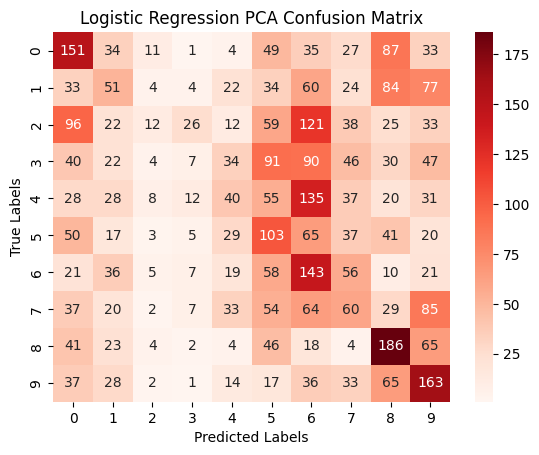

In [6]:
# create a confusion matrix from the pca predictions
cm = confusion_matrix(y_test, y_pred_test_pca)

sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Logistic Regression PCA Confusion Matrix")
plt.show()

In [7]:
# training a model on standardized data
lr = LogisticRegression(penalty=None, C=1.0, solver='saga', multi_class='multinomial', tol=0.01,
                                  max_iter=5000, verbose=2, random_state=27)
lr.fit(X_train_std, y_train)

convergence after 85 epochs took 141 seconds


LogisticRegression(max_iter=5000, multi_class='multinomial', penalty=None,
                   random_state=27, solver='saga', tol=0.01, verbose=2)

Train loss for logistic regression on standardized data is 1.324
Accuracy for the train data is 56.12%
Test loss for logistic regression on standardized data is 1.931
Accuracy for the test data is 35.77%


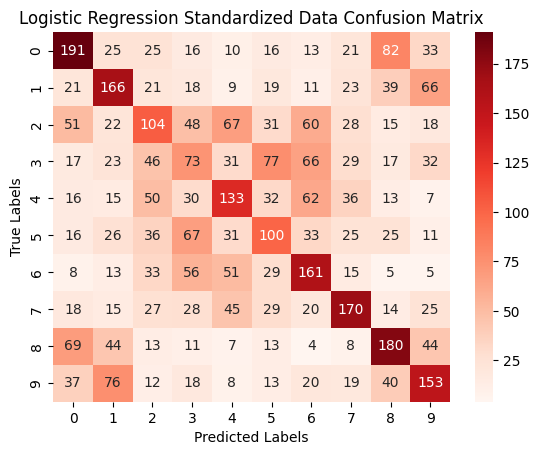

In [8]:
# model metrics and confusion matrix
y_pred_train_std = lr.predict_proba(X_train_std)
loss = log_loss(y_train, y_pred_train_std, labels = labels)
print(f'Train loss for logistic regression on standardized data is {loss:.3f}')

y_pred_train_std = lr.predict(X_train_std)
acc = accuracy_score(y_train, y_pred_train_std, normalize=True)
print(f'Accuracy for the train data is {acc*100:.2f}%')

y_pred_test_std = lr.predict_proba(X_test_std)
loss = log_loss(y_test, y_pred_test_std, labels = labels)
print(f'Test loss for logistic regression on standardized data is {loss:.3f}')

y_pred_test_std = lr.predict(X_test_std)
acc = accuracy_score(y_test, y_pred_test_std, normalize=True)
print(f'Accuracy for the test data is {acc*100:.2f}%')

cm = confusion_matrix(y_test, y_pred_test_std)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Logistic Regression Standardized Data Confusion Matrix")
plt.show()

In [10]:
# training a model on unprocessed data
lr = LogisticRegression(penalty=None, C=1.0, solver='saga', multi_class='multinomial', tol=0.01,
                                  max_iter=5000, verbose=2, random_state=27)
lr.fit(X_train, y_train)

Epoch 1, change: 1.00000000
Epoch 2, change: 0.30328576
Epoch 3, change: 0.17007875
Epoch 4, change: 0.11848450
Epoch 5, change: 0.09911796
Epoch 6, change: 0.07893755
Epoch 7, change: 0.06695584
Epoch 8, change: 0.05917072
Epoch 9, change: 0.05630970
Epoch 10, change: 0.05191058
Epoch 11, change: 0.04598829
Epoch 12, change: 0.04248832
Epoch 13, change: 0.03994053
Epoch 14, change: 0.03754246
Epoch 15, change: 0.03491296
Epoch 16, change: 0.03275857
Epoch 17, change: 0.03090118
Epoch 18, change: 0.02916235
Epoch 19, change: 0.02763691
Epoch 20, change: 0.02624667
Epoch 21, change: 0.02475788
Epoch 22, change: 0.02392449
Epoch 23, change: 0.02262858
Epoch 24, change: 0.02163340
Epoch 25, change: 0.02082528
Epoch 26, change: 0.01982496
Epoch 27, change: 0.01927104
Epoch 28, change: 0.01829863
Epoch 29, change: 0.01777308
Epoch 30, change: 0.01702729
Epoch 31, change: 0.01651036
Epoch 32, change: 0.01586565
Epoch 33, change: 0.01549990
Epoch 34, change: 0.01491526
Epoch 35, change: 0.014

LogisticRegression(max_iter=5000, multi_class='multinomial', penalty=None,
                   random_state=27, solver='saga', tol=0.01, verbose=2)

Train loss for logistic regression on standardized data is 1.494
Accuracy for the train data is 49.97%
Test loss for logistic regression on standardized data is 1.793
Accuracy for the test data is 38.30%


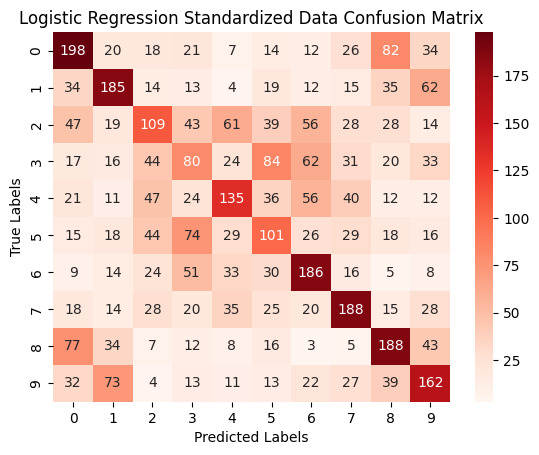

In [11]:
# model metrics and confusion matrix
y_pred_train = lr.predict_proba(X_train)
loss = log_loss(y_train, y_pred_train, labels = labels)
print(f'Train loss for logistic regression on standardized data is {loss:.3f}')

y_pred_train = lr.predict(X_train)
acc = accuracy_score(y_train, y_pred_train, normalize=True)
print(f'Accuracy for the train data is {acc*100:.2f}%')

y_pred_test = lr.predict_proba(X_test)
loss = log_loss(y_test, y_pred_test, labels = labels)
print(f'Test loss for logistic regression on standardized data is {loss:.3f}')

y_pred_test = lr.predict(X_test)
acc = accuracy_score(y_test, y_pred_test, normalize=True)
print(f'Accuracy for the test data is {acc*100:.2f}%')

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Logistic Regression Standardized Data Confusion Matrix")
plt.show()